In this notebook we will read output binary files from a montecarlo simulation of a SU(2) theory with an adjoint Higgs. The first cell is for reading and storing into arrays the measurements of the spectroscopical operators with quantum number J_p = 1_minus. There are 4 observable, one that we will call B, and other three, that we will call T_1,T_2 and T_3. There are 5 smearing levels, and 3 spatial directions. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc

import struct
Nt=8
w, h = 3, Nt
n_smear = 5
n_op = 4
n_meas = 100000
B = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T1 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
T2 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
T3 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]
b_l = w * 8
ck = b_l*Nt*n_op
Sm_ck = ck*n_smear


#B =list(range(Nt))
with  open("O1minus_output_files/output_Nt8_Nx8_Ny8_Nz8_B1.500000_K0.289200_L0.001100.bin","rb") as f:
    fileContent =f.read()
    for n in range(n_meas):
        for ns in range(n_smear):
            #print(ns)
            for t in range(Nt):
                B[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+b_l*t:(Sm_ck*n)+(ck*ns)+(t+1)*b_l])
                T1[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt)+(t+1)*b_l])
                T2[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+(t+1)*b_l])
                T3[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+(t+1)*b_l])
    
       

#print(B)        
#print(T1[0][Nt-1][2])
#print(T2[0][Nt-1][2])
#print(T3[0][Nt-1][2])

error: unpack requires a buffer of 24 bytes

Now we will calculate the correlator, for every measurement. The correlators are obtained as
C(t) = Sum_t' Sum_k O_k(t') O_k(t+t')

In [2]:
C = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
C1 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
C2 = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]
C3 = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]

for n in range(n_meas):
    for ns in range(n_smear):
        for t in range(Nt):
            for t_pr in range(Nt):
                for k in range(w):
                    C[n][ns][t] += B[n][ns][t_pr][k]*B[n][ns][(t_pr+t)%Nt][k]
                    C1[n][ns][t] += T1[n][ns][t_pr][k]*T1[n][ns][(t_pr+t)%Nt][k]
                    C2[n][ns][t] += T2[n][ns][t_pr][k]*T2[n][ns][(t_pr+t)%Nt][k]
                    C3[n][ns][t] += T3[n][ns][t_pr][k]*T3[n][ns][(t_pr+t)%Nt][k]
                
#print(C[2000])    

Now we will do statistical analysis to the correlators. We will obtain averages and error for the correlators, calculating autocorrelation as well.

In [3]:
C_res = [0 for y in range(3)]
#Cv = [0 for n in range(n_meas)]
C_res[0] =  np.mean(C,axis =0 )
C_res[1] = np.std(C,axis =0 )
C_res[2] = [[0 for t in range(Nt)]for sm in range(n_smear) ] 

print(C_res[1])

for ns in range(n_smear):
    for t in range(Nt):
        vec = []
        for n in range(n_meas):
            vec.append(float(C[n][ns][t]))
        C_res[2][ns][t] = phmc.integrated_autocorr6(np.array(vec),6)
        print(C_res[2][ns][t])
        C_res[1][ns][t] = C_res[1][ns][t]* np.sqrt(C_res[2][ns][t]/n_meas) 
        
print(C_res[2][0][1])        

[[2.62820356 0.87756774 0.87283224 0.87658191 1.23213169 0.87658191
  0.87283224 0.87756774]
 [2.83783533 0.94527654 0.94036606 0.94330973 1.32911222 0.94330973
  0.94036606 0.94527654]
 [3.07345458 1.02385657 1.02145293 1.02144295 1.44695848 1.02144295
  1.02145293 1.02385657]
 [3.29115883 1.09486504 1.0944503  1.09200837 1.55031429 1.09200837
  1.0944503  1.09486504]
 [3.47597021 1.1558432  1.15609122 1.15361364 1.63745395 1.15361364
  1.15609122 1.1558432 ]]
[10366.58110468]
[2.98314062]
[2.96304104]
[2.98562946]
[3.00369064]
[2.98562946]
[2.96304104]
[2.98314062]
[10356.1422725]
[2.98078412]
[2.94467037]
[2.95806271]
[3.01274143]
[2.95806271]
[2.94467037]
[2.98078412]
[10364.63945424]
[2.97835416]
[2.98875009]
[2.97348041]
[3.0171312]
[2.97348041]
[2.98875009]
[2.97835416]
[10366.08071435]
[2.97687752]
[3.02447278]
[3.0152502]
[3.00140346]
[3.0152502]
[3.02447278]
[2.97687752]
[10367.23448044]
[2.97470507]
[3.04097213]
[3.02413753]
[3.00289625]
[3.02413753]
[3.04097213]
[2.97470507

Now we plot the correlators for the operator B.

[3.5964836161710725, 0.005190629558313872, 0.000524718859775553, -0.006844902581502511, -0.00169865213593584, -0.006844902581502517, 0.0005247188597755465, 0.005190629558313866]
[3.8776369246874123, 0.005861286382528726, 0.003963563584457706, -0.004708459072325723, -0.0014114558054476153, -0.0047084590723257234, 0.0039635635844577, 0.00586128638252874]
[4.201696190988746, 0.002645556564228978, 0.00686224506289382, -0.0037092323304941236, -0.003240586995389286, -0.0037092323304941375, 0.006862245062893817, 0.002645556564228976]
[4.500019466828134, 0.0030446966873016157, 0.007022303315240826, -0.002691343576179072, -0.002982227190418108, -0.002691343576179069, 0.007022303315240829, 0.0030446966873016144]
[4.753564793839997, 0.003396252674552797, 0.006398513167938013, -0.00300828004292504, -0.0022621914292278054, -0.0030082800429250376, 0.006398513167938011, 0.0033962526745527815]


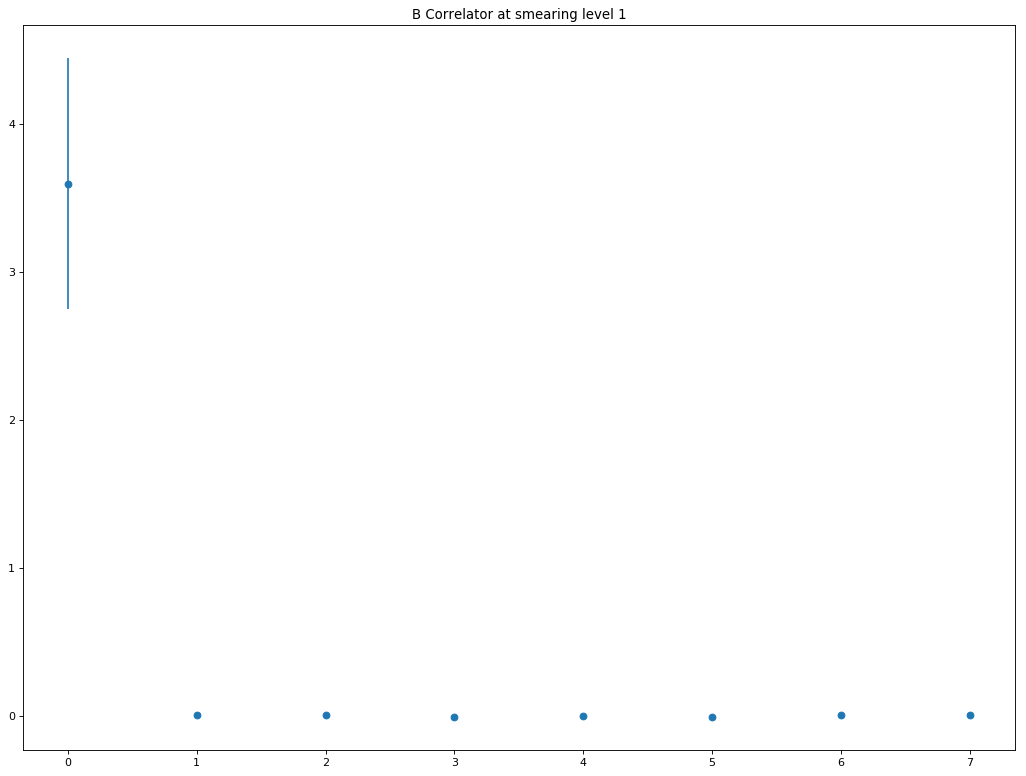

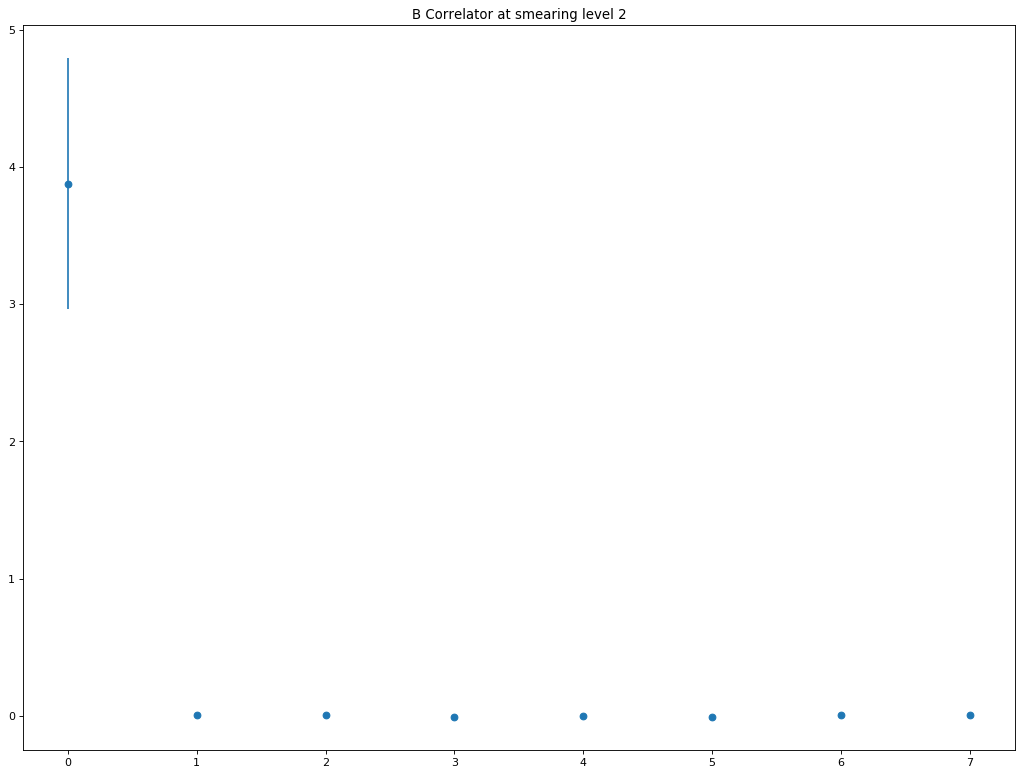

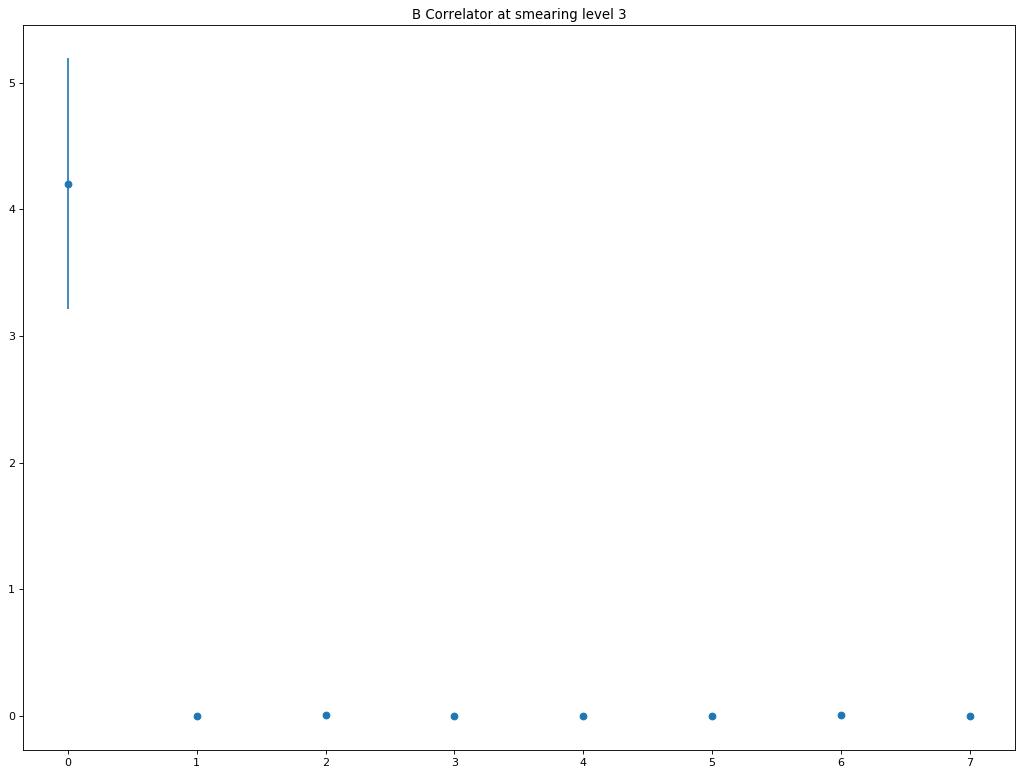

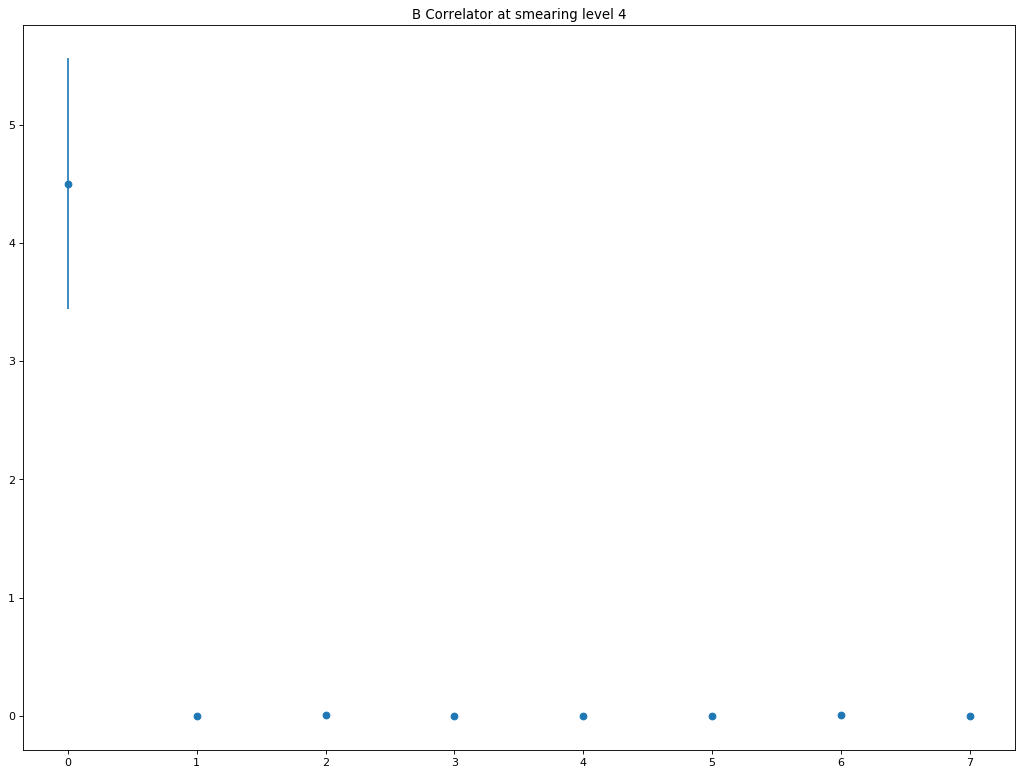

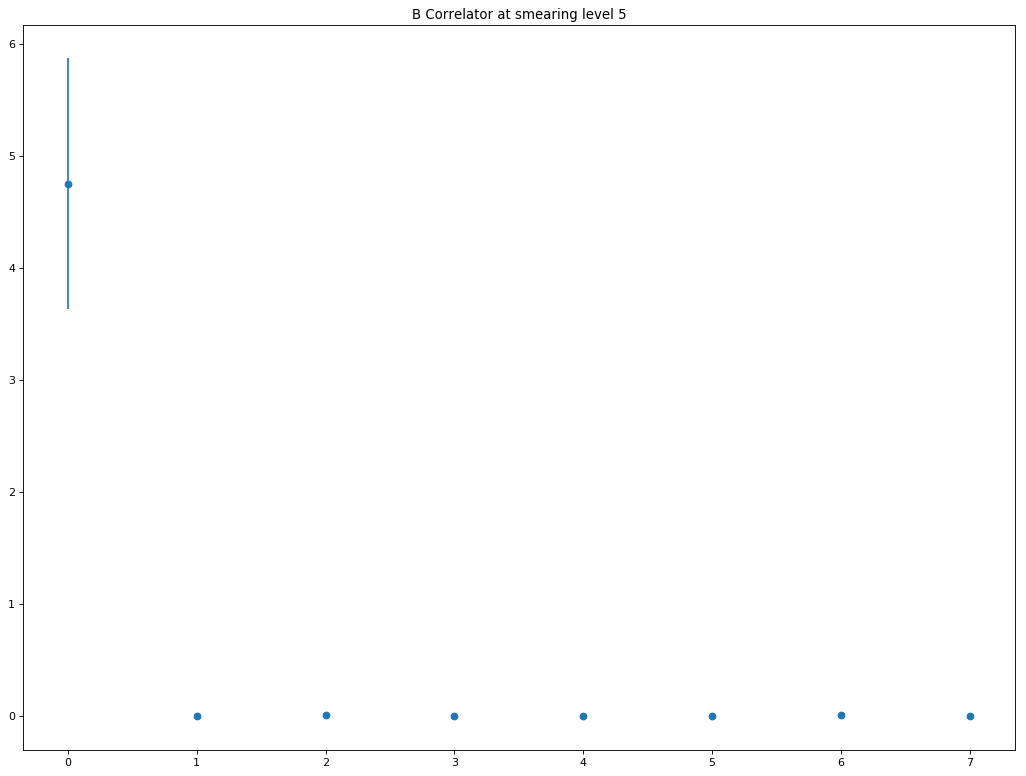

In [4]:
T = list(range(Nt))
C_avg = list(range(Nt))
C_err = list(range(Nt))

for ns in range(n_smear):
    for t in range(Nt):
        C_avg[t] = C_res[0][ns][t]
        C_err[t] = C_res[1][ns][t]
    
    print(C_avg)
    
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(T,C_avg,C_err,fmt='o',label = 'data')
    plt.title("B Correlator at smearing level %d" % (ns+1))

Now we plot the effective masses resultant from the correlators.

/home/vincenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


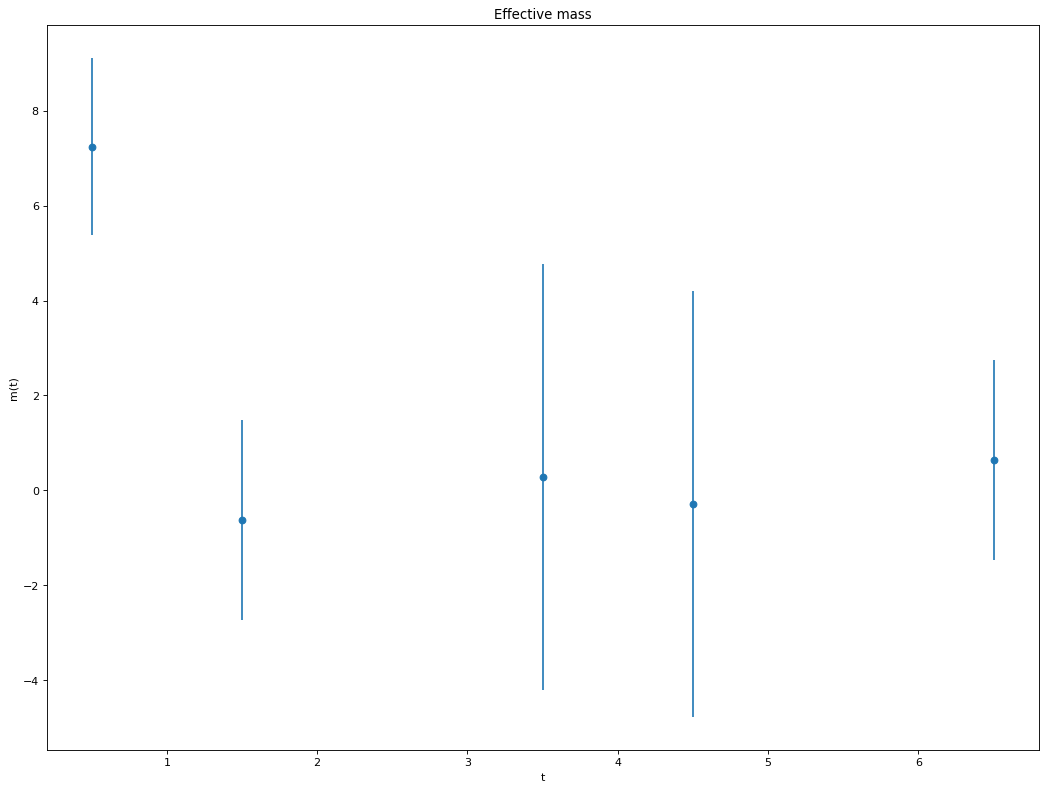

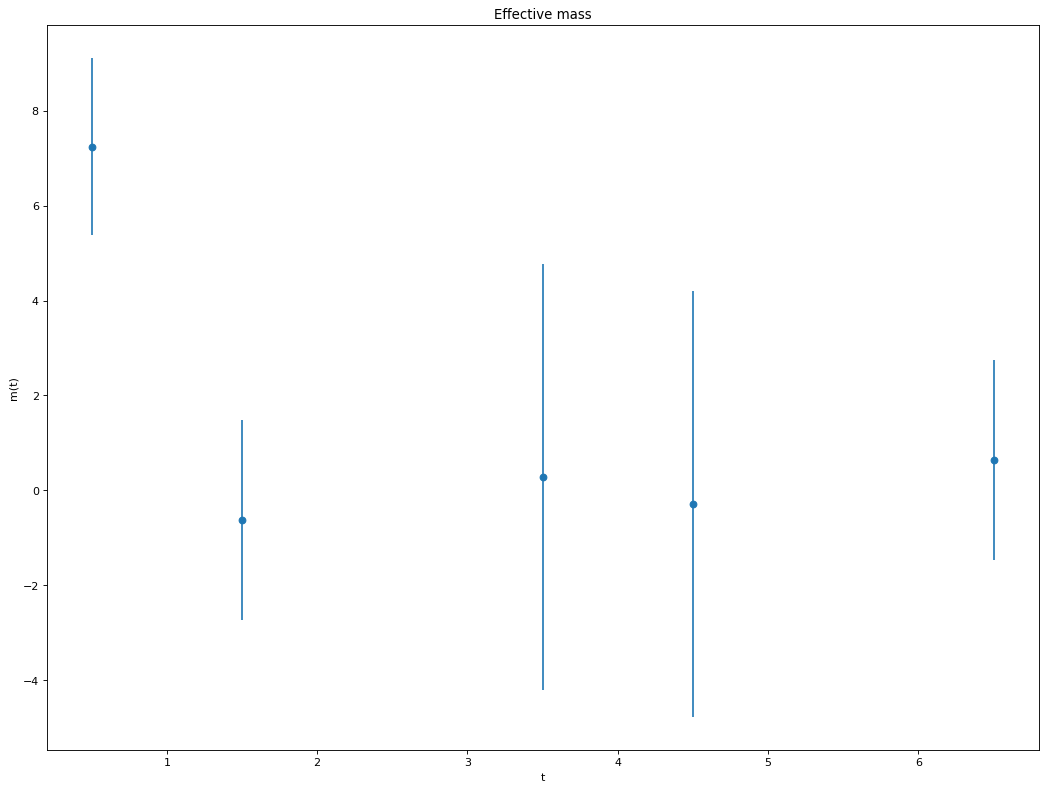

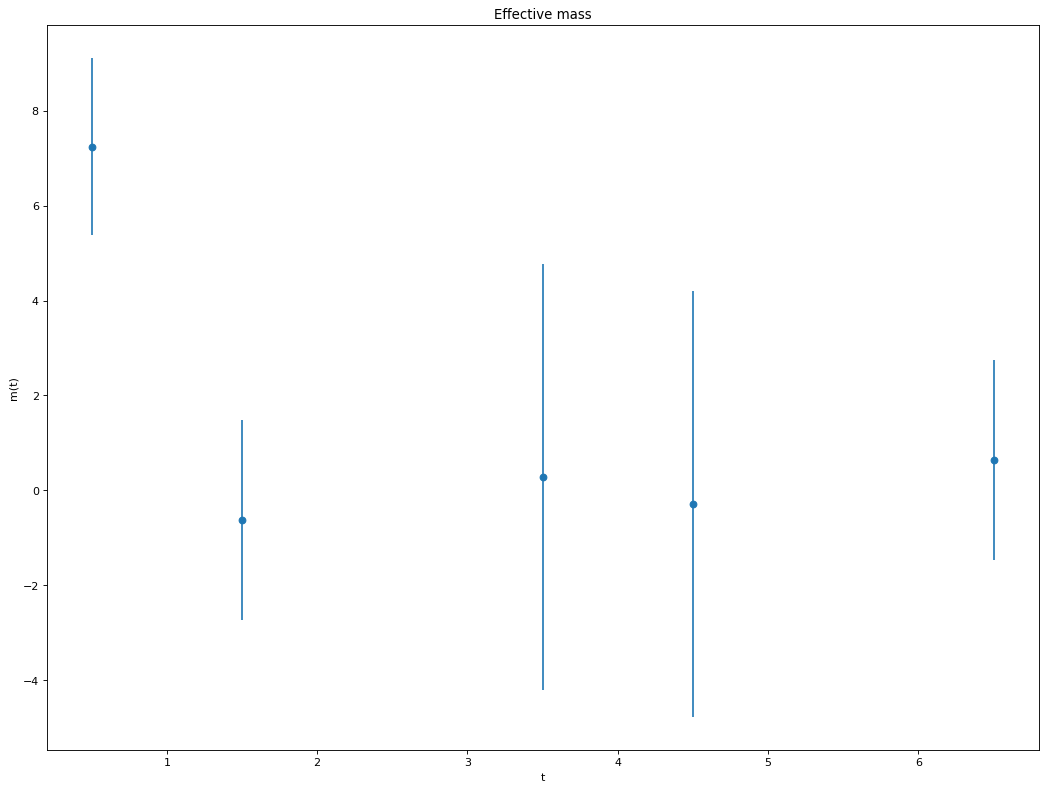

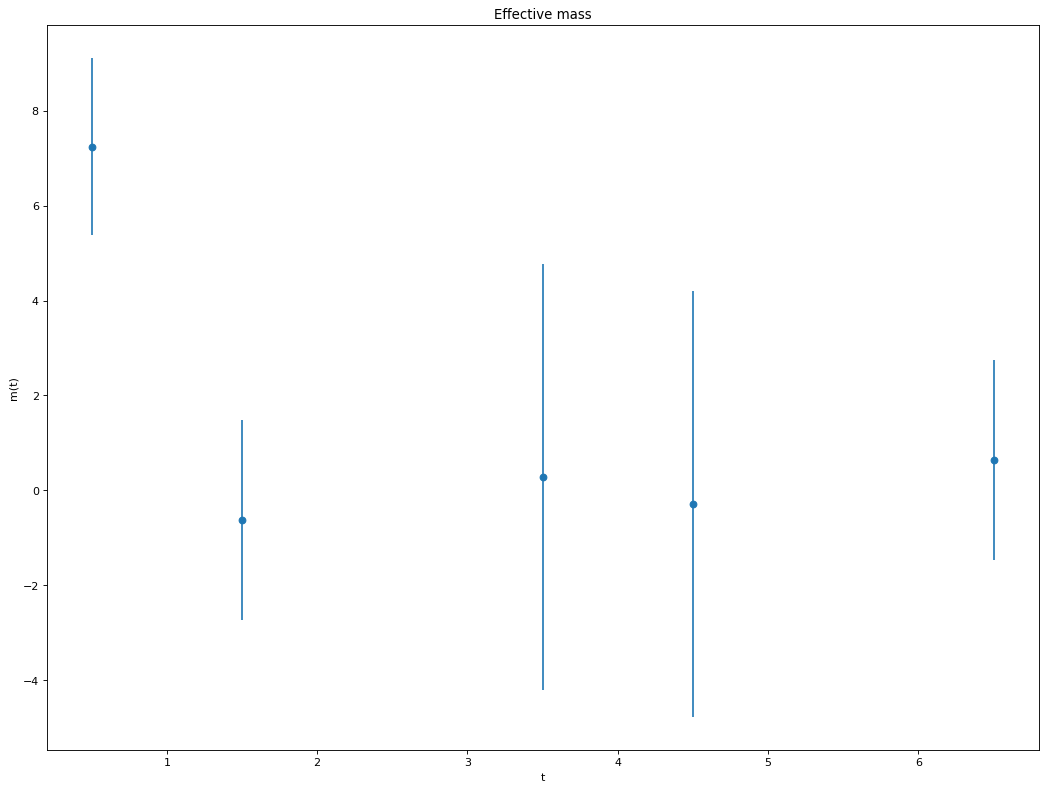

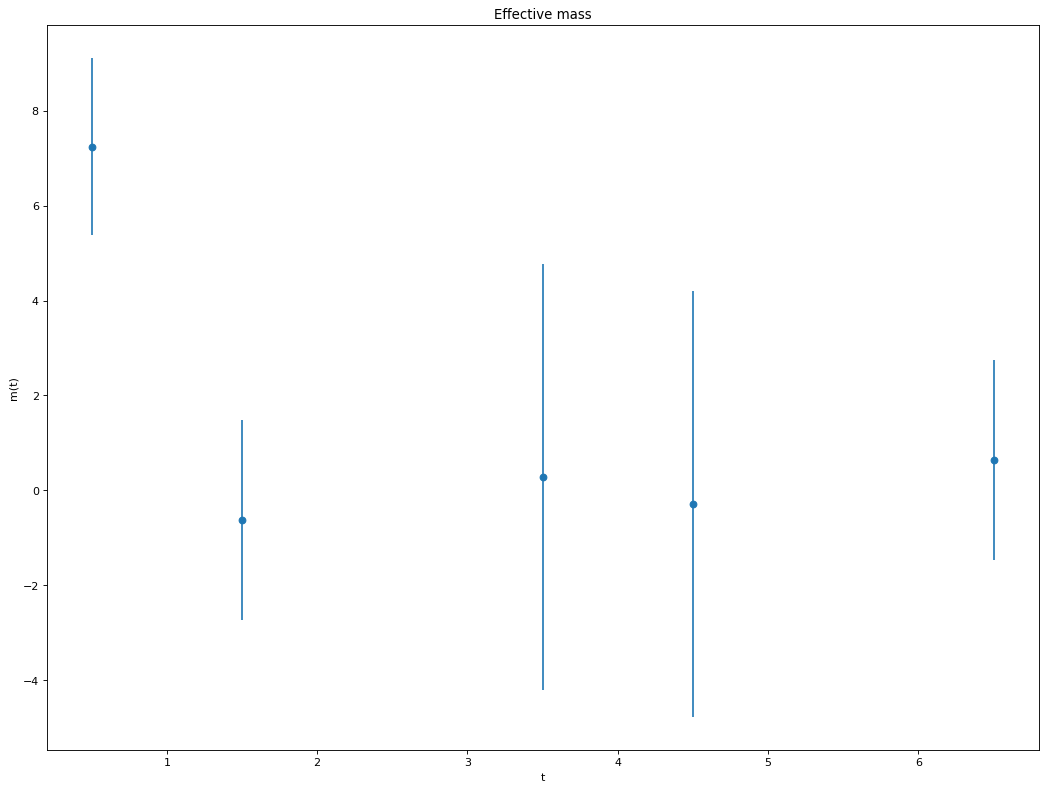

In [5]:
Tm = list(range(Nt-1))
m = list(range(Nt-1))
m_unc = list(range(Nt-1))

for ns in range(n_smear):
    for t in range(Nt-1):
        Tm[t] = t +0.5
        m[t] = np.log(C_avg[t]/C_avg[t+1])
        m_unc[t] = np.sqrt( (C_err[t]/C_avg[t])**2 + (C_err[t+1]/C_avg[t+1])**2 )
        
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.errorbar(Tm, m,m_unc,fmt='o')
    plt.xlabel("t")
    plt.ylabel("m(t)")
    #plt.yscale("log")
    plt.title("Effective mass")